# Submission Guidelines

1.   Replace the "Student ID" of the notebook name with your Student ID.
2.   Download your solution in IPYNB format.
3.   Submit it in the designated post of Google Classroom before 11:30 AM.
4.   Click on `Turn In` to confirm your submission.

( `Make a copy` of this file. All three (3) tasks should be in one ipynb.)

The FruitNet dataset provides the image samples of 6 different fruits (Apple, Banana, Guava, Lime, Orange, Pomegranate) in three different quality conditions (Good, Bad, and Mixed).

In [ ]:
!gdown --id 17dVysAClgfsoKQJQ6iaS5su_LmIT7q0N
!unzip -qq FruitNet.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=17dVysAClgfsoKQJQ6iaS5su_LmIT7q0N 

unzip:  cannot find or open FruitNet.zip, FruitNet.zip.zip or FruitNet.zip.ZIP.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_path = '/content/drive/MyDrive/FruitNet'
!unzip -qq /content/drive/MyDrive/FruitNet.zip

# Task Description - 001 (Points: 10)<br>
Pick a random image from the dataset. Then apply two consecutive convolution operations with a $5\times5$ kernel, stride - 2, and padding - 2 followed by a average pooling layer. Show the output after each operation. 

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def rgb2gray(rgb):
  r,g,b = rgb[:, :, 0],rgb[:, :, 1], rgb[:, :, 2]
  gray = 0.2989 * r + 0.5870*g + 0.1140*b
  return gray 

In [ ]:
def load_image(path):
  img = Image.open(path) # rgb image
  img = img.resize((256, 256))
  img = np.array(img) # converting to an numpy array
  return rgb2gray(img)

In [ ]:
img = load_image('/content/FruitNet/train/Apple_Good/Apple_Good (1013).jpg')
print(img.shape)

(256, 256)


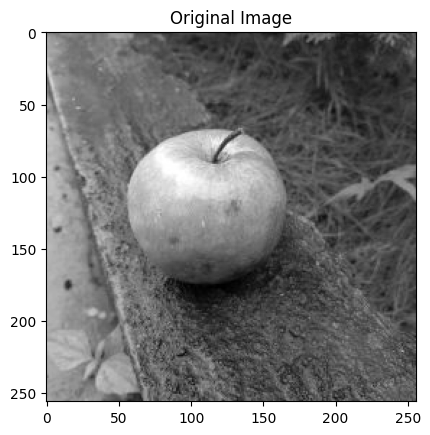

In [ ]:
plt.imshow(img, cmap = 'gray')
plt.title("Original Image")
plt.show()

In [ ]:
def Conv2D(image, kernel, stride=1, padding=0):
    x, y = image.shape
    m, n = kernel.shape
    padded_image = np.pad(image, padding, mode='constant')  # Apply padding to the image

    output_height = int((x + 2 * padding - m) / stride) + 1
    output_width = int((y + 2 * padding - n) / stride) + 1
    output = np.zeros((output_height, output_width))

    for i in range(0, output_height):
        for j in range(0, output_width):
            image_patch = padded_image[i*stride : i*stride + m, j * stride:j * stride + n]
            output[i, j] = np.sum(image_patch * kernel)

    return output

In [ ]:
kernel = np.array([
    [1,1,1,1,1],
    [1,1,1,1,1], 
    [0,0,0,0,0], 
    [-1,-1,-1,-1,-1],
    [-1,-1,-1,-1,-1]
])

conv_output = Conv2D(img, kernel, 2, 2)
conv_output.shape

(128, 128)

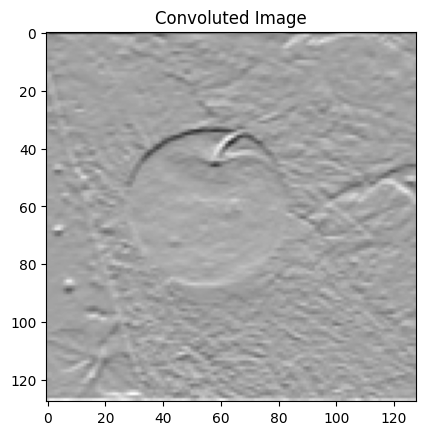

In [ ]:
plt.imshow(conv_output, cmap = 'gray')
plt.title('Convoluted Image')
plt.show()

In [ ]:
def Avgpool2D(image, pool_size):
  x,y = image.shape
  x = x // pool_size
  y = y // pool_size

  output = np.zeros((x,y))

  for i in range(x):
    for j in range(y):
      output[i][j] = np.average(image[i*pool_size:i*pool_size + pool_size,j*pool_size:j*pool_size + pool_size])
  return output

In [ ]:
avgpool_output = Avgpool2D(conv_output, 2)
avgpool_output.shape

(64, 64)

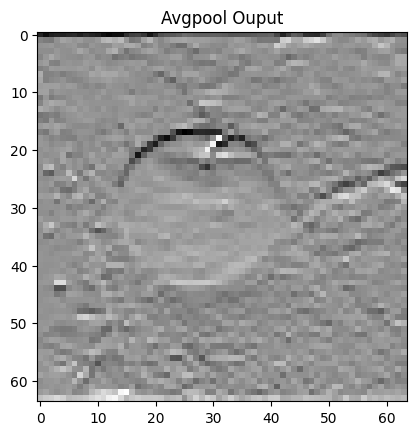

In [ ]:
plt.imshow(avgpool_output, cmap ='gray')
plt.title('Avgpool Ouput')
plt.show()

In [ ]:
kernel = np.array([
    [1,1,1,1,1],
    [1,1,1,1,1], 
    [0,0,0,0,0], 
    [-1,-1,-1,-1,-1],
    [-1,-1,-1,-1,-1]
])

conv_output = Conv2D(avgpool_output, kernel, 2, 2)
conv_output.shape

(32, 32)

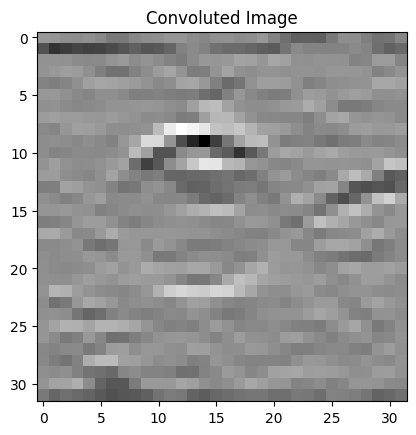

In [ ]:
plt.imshow(conv_output, cmap = 'gray')
plt.title('Convoluted Image')
plt.show()

In [ ]:
avgpool_output = Avgpool2D(conv_output, 2)
avgpool_output.shape

(16, 16)

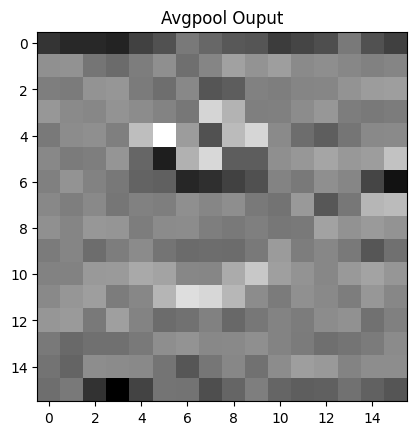

In [ ]:
plt.imshow(avgpool_output, cmap ='gray')
plt.title('Avgpool Ouput')
plt.show()

# Task Description - 002 (Points: 15)<br>
Using the three provided classes (`Good`, `Bad`, and `Mixed`), implement a CNN architecture to classify fruit qualities from a given image (of any fruit) as shown in the Figure (LeNet). The final output class should have 3 units instead of 10 in the figure. Subsequently, train your model for 10 epochs. Make sure to turn on the GPU option in colab before starting your training.<br>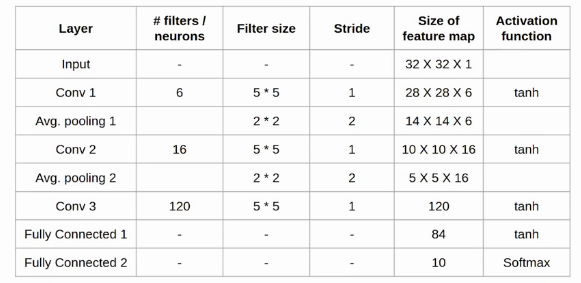

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras import datasets, layers, models, losses, optimizers
from tensorflow.keras.utils import to_categorical
import os
import cv2
import glob

In [ ]:
files = glob.glob('FruitNet/*/*/*')
print(files[67])

FruitNet/train/Banana_Good/Banana_Good (747).JPG


In [ ]:
test_img = files[67]
img = cv2.imread(test_img, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (0,0), fx=0.125, fy=0.125)
img = np.reshape(img, newshape=(32, 32, 1))
img.shape

(32, 32, 1)

In [ ]:
X_train = []
X_val = []
X_test = []
y_train = []
y_val = []
y_test = []

for f in files:
  img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, (0,0), fx=0.125, fy=0.125)
  if img.shape != (32,32):
    continue
  img = np.reshape(img, newshape=(32, 32, 1))
  if 'train' in f:
    X_train.append(img)
    if 'Good' in f:
      y_train.append([1., 0., 0.])
    elif 'Bad' in f:
      y_train.append([0., 1., 0.])
    elif 'Mixed' in f:
      y_train.append([0., 0., 1.])

  elif 'val' in f:
    X_val.append(img)
    if 'Good' in f:
      y_val.append([1., 0., 0.])
    elif 'Bad' in f:
      y_val.append([0., 1., 0.])
    elif 'Mixed' in f:
      y_val.append([0., 0., 1.])

  elif 'test' in f:
    X_test.append(img)
    if 'Good' in f:
      y_test.append([1., 0., 0.])
    elif 'Bad' in f:
      y_test.append([0., 1., 0.])
    elif 'Mixed' in f:
      y_test.append([0., 0., 1.])


X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_train.shape

(7449, 32, 32, 1)

In [ ]:
y_train.shape

(7449, 3)

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(6, (5,5), activation ='tanh', input_shape =(32,32,1)))
model.add(layers.AveragePooling2D((2,2)))

model.add(layers.Conv2D(16 , (5,5), activation ='tanh'))
model.add(layers.AveragePooling2D((2,2)))

model.add(layers.Conv2D(120 , (5,5), activation ='tanh'))

model.add(layers.Flatten())
model.add(layers.Dense(84, activation = 'tanh'))
model.add(layers.Dense(3, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_17 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_27 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_18 (Avera  (None, 5, 5, 16)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_28 (Conv2D)          (None, 1, 1, 120)         48120     
                                                                 
 flatten_7 (Flatten)         (None, 120)             

In [94]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=10,
                    validation_data=(X_val, y_val)
                    )

Epoch 1/10
745/745 [==============================] - 8s 6ms/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.0762 - val_accuracy: 0.9918
Epoch 2/10
745/745 [==============================] - 5s 7ms/step - loss: 0.0117 - accuracy: 0.9973 - val_loss: 0.0409 - val_accuracy: 0.9953
Epoch 3/10
745/745 [==============================] - 5s 6ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.0378 - val_accuracy: 0.9953
Epoch 4/10
745/745 [==============================] - 4s 5ms/step - loss: 0.0017 - accuracy: 0.9989 - val_loss: 0.0516 - val_accuracy: 0.9937
Epoch 5/10
745/745 [==============================] - 5s 7ms/step - loss: 0.0057 - accuracy: 0.9984 - val_loss: 0.0429 - val_accuracy: 0.9937
Epoch 6/10
745/745 [==============================] - 5s 6ms/step - loss: 0.0053 - accuracy: 0.9979 - val_loss: 0.0545 - val_accuracy: 0.9918
Epoch 7/10
745/745 [==============================] - 4s 6ms/step - loss: 0.0020 - accuracy: 0.9989 - val_loss: 0.0487 - val_accuracy: 0.9941
Epoch 

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# Task Description - 003 (Points: 15)<br>
Finally, improve your architecture based on the knowledge gained in this course and re-train the model. Write the changes you incorporated over the vanilla LeNet and the findings in the markdown field in this notebook for ease of evaluation.

In [ ]:
# Write your codes here.
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
model.add(AveragePooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model.add(AveragePooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(120, kernel_size=(5, 5), activation='relu'))
model.add(Flatten())

model.add(Dense(84, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(24, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_30 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_25 (Bat  (None, 14, 14, 6)        24        
 chNormalization)                                                
                                                                 
 conv2d_46 (Conv2D)          (None, 12, 12, 16)        880       
                                                                 
 average_pooling2d_31 (Avera  (None, 6, 6, 16)         0         
 gePooling2D)                                                    
                                                     

In [86]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [88]:
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=10,
                    validation_data=(X_val, y_val)
                    )

Epoch 1/10
745/745 [==============================] - 5s 6ms/step - loss: 0.0092 - accuracy: 0.9964 - val_loss: 0.2676 - val_accuracy: 0.9196
Epoch 2/10
745/745 [==============================] - 4s 6ms/step - loss: 0.0113 - accuracy: 0.9961 - val_loss: 0.0529 - val_accuracy: 0.9867
Epoch 3/10
745/745 [==============================] - 5s 6ms/step - loss: 0.0051 - accuracy: 0.9979 - val_loss: 0.3803 - val_accuracy: 0.9255
Epoch 4/10
745/745 [==============================] - 5s 6ms/step - loss: 0.0116 - accuracy: 0.9968 - val_loss: 0.0415 - val_accuracy: 0.9906
Epoch 5/10
745/745 [==============================] - 4s 6ms/step - loss: 0.0119 - accuracy: 0.9962 - val_loss: 0.0222 - val_accuracy: 0.9937
Epoch 6/10
745/745 [==============================] - 5s 7ms/step - loss: 0.0022 - accuracy: 0.9991 - val_loss: 0.0327 - val_accuracy: 0.9929
Epoch 7/10
745/745 [==============================] - 4s 6ms/step - loss: 0.0156 - accuracy: 0.9945 - val_loss: 0.0603 - val_accuracy: 0.9816
Epoch 

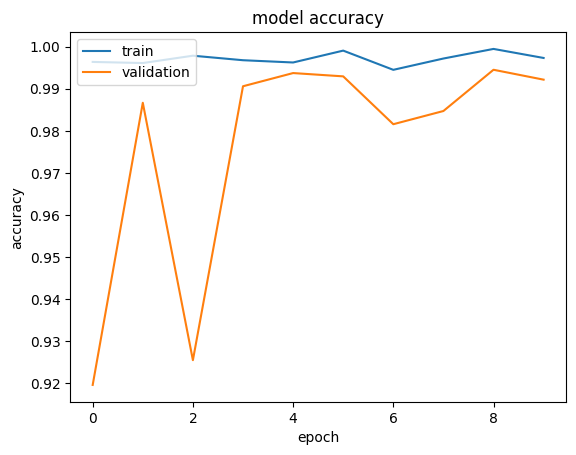

In [92]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

## Changes Suggested


1.   ReLu activation function instead of tanh
2.   Using dropout and batch normalization for regularization
3.   Increase the depth of the model

## Findings/Observations


1.   Increased training speed and accuracy
2.   Improved generalization
3.   Better at finding patterns than before



